## Importing Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [249]:
df = pd.read_csv("co-emissions-by-sector.csv")
df=df[['Year', 'Industry']]
df.to_csv("CO2_data_industries.csv")

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      29 non-null     int64  
 1   Industry  29 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 592.0 bytes


In [251]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("CO2_data_industries.csv",parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df=df.drop('Unnamed: 0',axis=1)
df.rename({'Industry':'CO2'},axis=1,inplace=True)
df.head()


,CO2
Year,
1990-01-01,0.03348
1991-01-01,0.03274
1992-01-01,0.03299
1993-01-01,0.03484
1994-01-01,0.03631


<AxesSubplot:xlabel='CO2'>

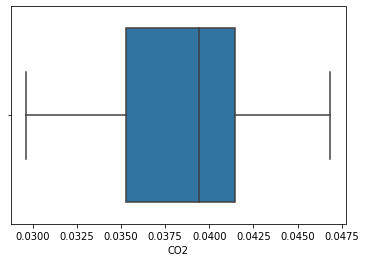

In [252]:
sns.boxplot(df['CO2'])

<AxesSubplot:xlabel='Year'>

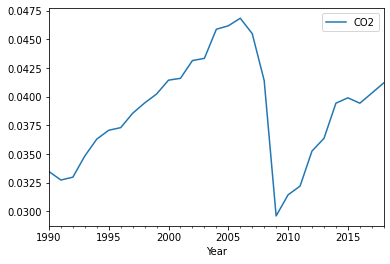

In [253]:
df.plot()

## Transforming data to normal distribution

In [254]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

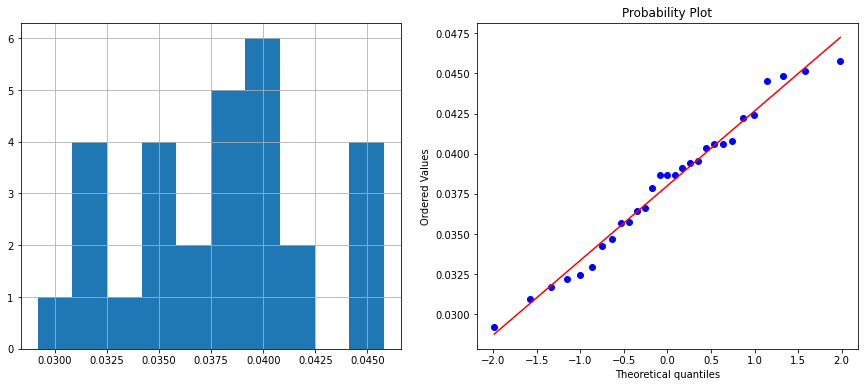

In [255]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

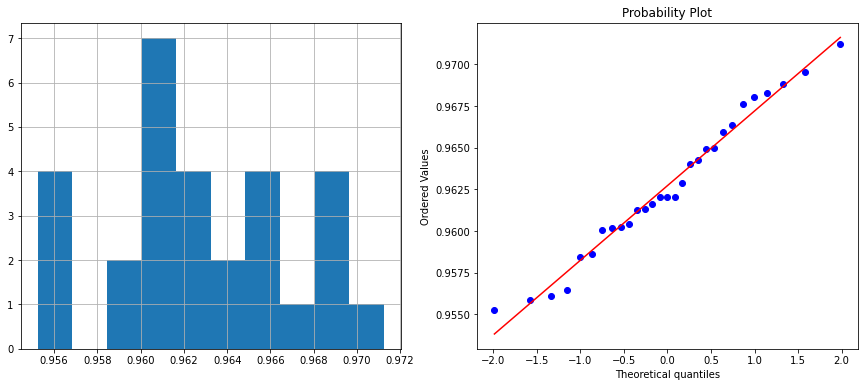

In [256]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

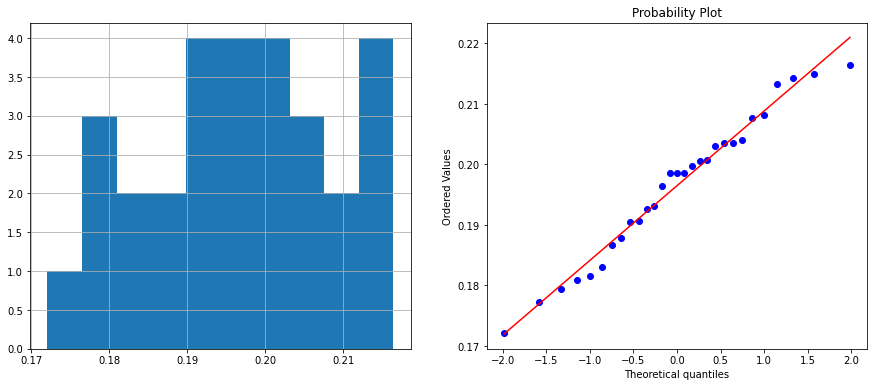

In [257]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

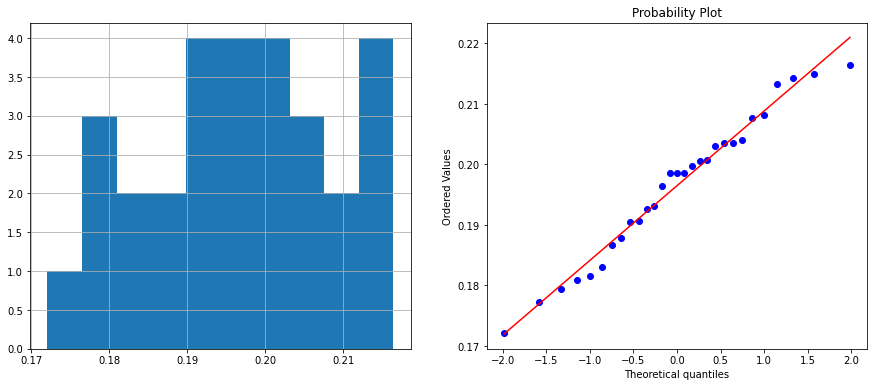

In [258]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  10.003965442129243


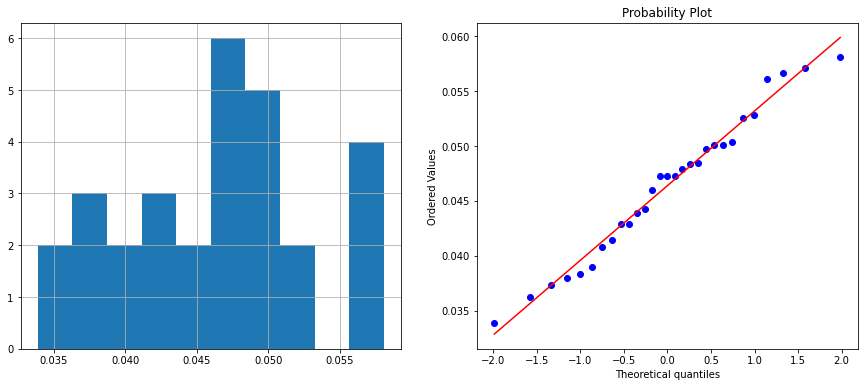

In [259]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-1.14162474, -1.14176832,  1.1390155 , -1.14162474, -1.14162474,
        -1.14050678],
       [-1.2976683 , -1.29784299,  1.29216458, -1.2976683 , -1.29766829,
        -1.29626789],
       [-1.24502808, -1.24519339,  1.24053547, -1.24502808, -1.24502808,
        -1.24371533],
       [-0.85306836, -0.85313474,  0.85496505, -0.85306836, -0.85306836,
        -0.85260457],
       [-0.53866012, -0.53863036,  0.5441364 , -0.53866012, -0.53866012,
        -0.53897572],
       [-0.37295626, -0.37287746,  0.37972974, -0.37295626, -0.37295626,
        -0.37366043],
       [-0.32332755, -0.32323485,  0.33040766, -0.32332755, -0.32332755,
        -0.32414079],
       [-0.05255555, -0.05239745,  0.06062483, -0.05255555, -0.05255556,
        -0.0538745 ],
       [ 0.14348111,  0.14367132, -0.13543735,  0.14348111,  0.14348111,
         0.14192227],
       [ 0.31409688,  0.31430125, -0.30659873,  0.31409688,  0.31409688,
         0.31244109],
       [ 0.58006292,  0.58025796, -0.57441535,  0.

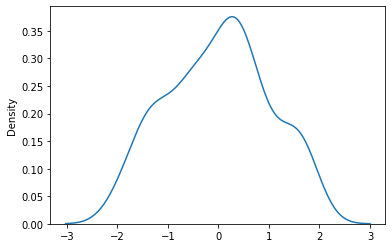

In [260]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

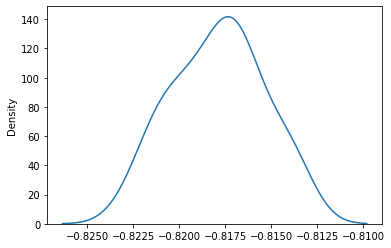

In [261]:

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [262]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Year'>

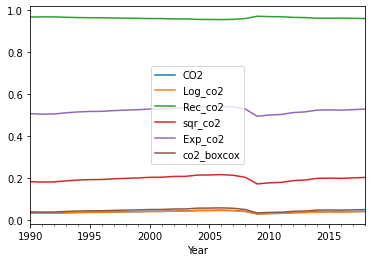

In [263]:
df.plot()

<AxesSubplot:xlabel='Year'>

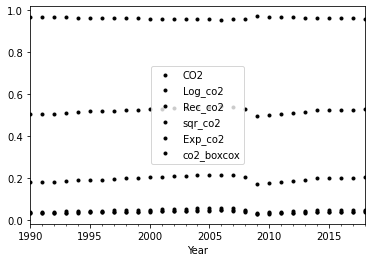

In [116]:
df.plot(style = 'k.')

In [264]:
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.038747,0.038006,0.962717,0.196490,0.521372,0.046384
std,0.004687,0.004513,0.004345,0.011987,0.012790,0.006593
min,0.029610,0.029180,0.955247,0.172076,0.494638,0.033886
25%,0.035270,0.034662,0.960200,0.187803,0.512249,0.041431
50%,0.039440,0.038682,0.962056,0.198595,0.523826,0.047233
75%,0.041450,0.040614,0.965932,0.203593,0.529060,0.050106
max,0.046850,0.045786,0.971242,0.216449,0.542178,0.058074


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'Log_co2'}>],
       [<AxesSubplot:title={'center':'Rec_co2'}>,
        <AxesSubplot:title={'center':'sqr_co2'}>],
       [<AxesSubplot:title={'center':'Exp_co2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>]], dtype=object)

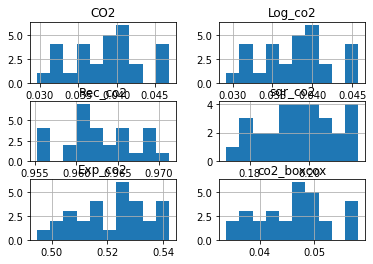

In [265]:
df.hist()

Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

#### Dropping all transformed values from dataset

In [266]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [267]:
df.head(n=35)

,CO2
Year,
1990-01-01,0.03348
1991-01-01,0.03274
1992-01-01,0.03299
1993-01-01,0.03484
1994-01-01,0.03631
1995-01-01,0.03708
1996-01-01,0.03731
1997-01-01,0.03856
1998-01-01,0.03946


In [121]:
len(df)

29

In [122]:
df.dtypes

CO2    float64
dtype: object

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1990-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


<AxesSubplot:xlabel='Year'>

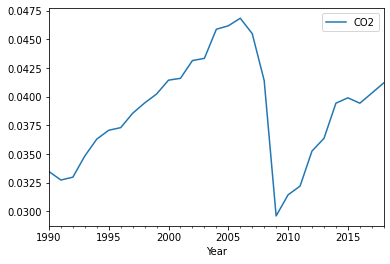

In [124]:
df.plot()

<AxesSubplot:xlabel='Year'>

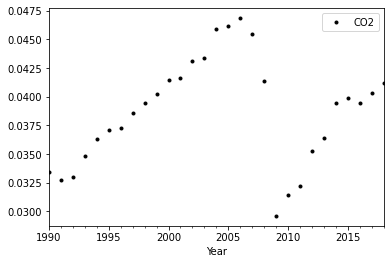

In [125]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [126]:
df.describe()

,CO2
count,29.000000
mean,0.038747
std,0.004687
min,0.029610
25%,0.035270
50%,0.039440
75%,0.041450
max,0.046850


array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

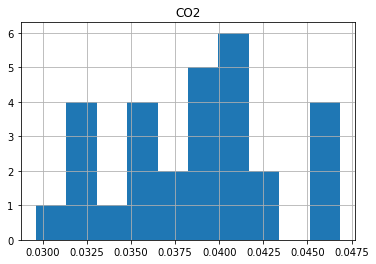

In [268]:
df.hist()

# A) MODEL BUILDING ON STATIONARY DATA

## Test Stationary

Naive test for stationary by checking constant mean and variance

In [269]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.038041, mean2=0.039406
variance1=0.000012, variance2=0.000028


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [270]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 5, center = False).mean()
    rol_std = df.rolling(window = 5, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [271]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

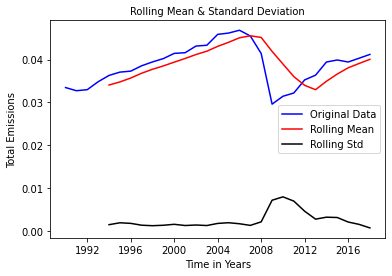

In [272]:
TestStationaryPlot(df)

In [273]:
TestStationaryAdfuller(df)

Test Statistic                 -2.387521
p-value                         0.145290
#Lags Used                      1.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary. 

## Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

### 1. Moving Average

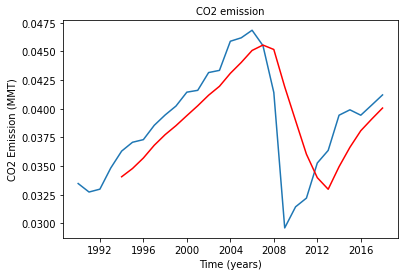

In [274]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [275]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,NaN
1993-01-01,NaN
1994-01-01,0.002238
1995-01-01,0.002288
1996-01-01,0.001604
1997-01-01,0.001740
1998-01-01,0.001716


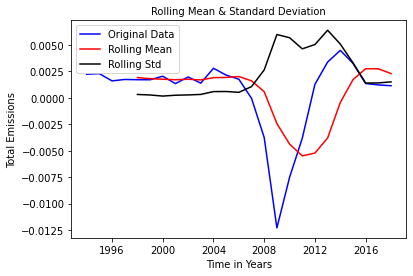

In [276]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [277]:
moving_avg.dropna(inplace=True)
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                 -2.697662
p-value                         0.074444
#Lags Used                      1.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

### 2. Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

#### 2(A) : First order differencing

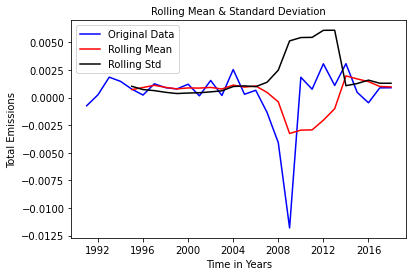

In [278]:
df_first_difference = df - df.shift(1)
#df_first_difference.head()
df.shift(1)
TestStationaryPlot(df_first_difference.dropna(inplace=False))


In [279]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                 -3.878272
p-value                         0.002201
#Lags Used                      0.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64
Failed to reject null hypothesis. Data is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

#### 2(B) : Seasonal First order differencing

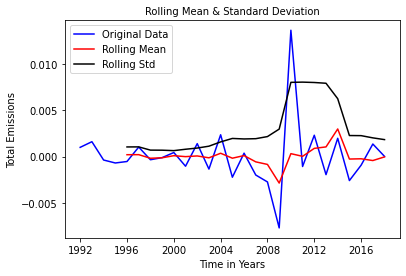

In [280]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [281]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -7.506528e+00
p-value                        4.120674e-11
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+01
Critical Value (1%)           -3.711212e+00
Critical Value (5%)           -2.981247e+00
Critical Value (10%)          -2.630095e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


We are considering this seasonal first difference for further analysis because it looks more stationary

### 3. Eliminating trend and seasonality: Decomposing

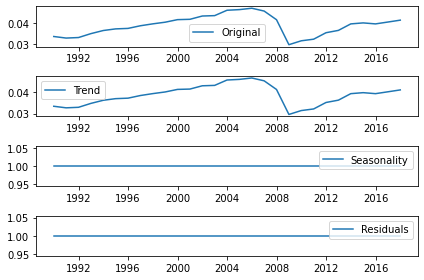

In [282]:
decomposition = seasonal_decompose(df,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

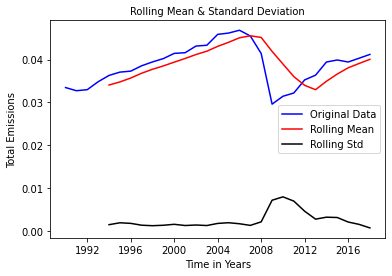

Test Statistic                 -2.387521
p-value                         0.145290
#Lags Used                      1.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [283]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

## Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

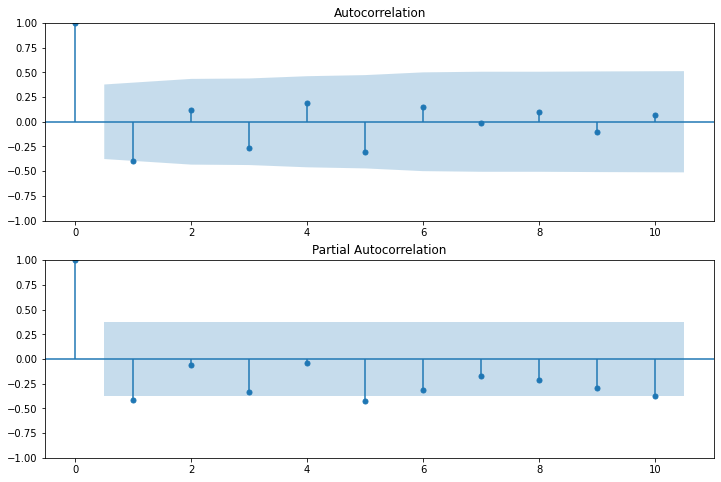

In [284]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [285]:
#using seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1990-01-01,NaN
1991-01-01,NaN
1992-01-01,0.00099
1993-01-01,0.00160
1994-01-01,-0.00038


In [286]:
X = df_seasonal_first_difference.dropna(inplace=False)

In [287]:
X.head(n=30)

,CO2
Year,
1992-01-01,0.00099
1993-01-01,0.00160
1994-01-01,-0.00038
1995-01-01,-0.00070
1996-01-01,-0.00054
1997-01-01,0.00102
1998-01-01,-0.00035
1999-01-01,-0.00012
2000-01-01,0.00043


In [288]:
len(X)

27

In [289]:
# Create Training and Test
train = X.iloc[:20]
test = X.iloc[20:]

In [290]:
print(train.shape,test.shape)

(20, 1) (7, 1)


In [150]:
train.head()

,CO2
Year,
1992-01-01,0.00099
1993-01-01,0.00160
1994-01-01,-0.00038
1995-01-01,-0.00070
1996-01-01,-0.00054


In [151]:
test.head()

,CO2
Year,
2012-01-01,0.00230
2013-01-01,-0.00196
2014-01-01,0.00197
2015-01-01,-0.00260
2016-01-01,-0.00094


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [291]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [292]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [61]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.002
ARIMA(0, 0, 1) RMSE=0.002
ARIMA(0, 0, 2) RMSE=0.003
ARIMA(0, 1, 0) RMSE=0.003
ARIMA(0, 1, 1) RMSE=0.002
ARIMA(0, 1, 2) RMSE=0.003
ARIMA(0, 2, 0) RMSE=0.009
ARIMA(0, 2, 1) RMSE=0.003
ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 0, 0) RMSE=0.001
ARIMA(1, 0, 1) RMSE=0.002
ARIMA(1, 0, 2) RMSE=0.003
ARIMA(1, 1, 0) RMSE=0.004
ARIMA(1, 1, 1) RMSE=0.002
ARIMA(1, 1, 2) RMSE=0.002
ARIMA(1, 2, 0) RMSE=0.006
ARIMA(1, 2, 1) RMSE=0.006
ARIMA(1, 2, 2) RMSE=0.005
ARIMA(2, 0, 0) RMSE=0.004
ARIMA(2, 0, 1) RMSE=0.002
ARIMA(2, 0, 2) RMSE=0.003
ARIMA(2, 1, 0) RMSE=0.003
ARIMA(2, 1, 1) RMSE=0.004
ARIMA(2, 1, 2) RMSE=0.002
ARIMA(2, 2, 0) RMSE=0.008
ARIMA(2, 2, 1) RMSE=0.004
ARIMA(2, 2, 2) RMSE=0.007
ARIMA(3, 0, 0) RMSE=0.003
ARIMA(3, 0, 1) RMSE=0.004
ARIMA(3, 0, 2) RMSE=0.003
ARIMA(3, 1, 0) RMSE=0.004
ARIMA(3, 1, 1) RMSE=0.004
ARIMA(3, 1, 2) RMSE=0.004
ARIMA(3, 2, 0) RMSE=0.007
ARIMA(3, 2, 1) RMSE=0.004
ARIMA(3, 2, 2) RMSE=0.005
ARIMA(4, 0, 0) RMSE=0.004
ARIMA(4, 0, 1) RMSE=0.004
ARIMA(4, 0, 

## ARIMA model

In [293]:
#1,0,0
model_arima = ARIMA(train['CO2'],order = (1,0,0))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  84.890
Date:                Sun, 10 Apr 2022   AIC                           -163.779
Time:                        01:18:51   BIC                           -160.792
Sample:                    01-01-1992   HQIC                          -163.196
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.351e-05      0.001      0.109      0.913      -0.001       0.001
ar.L1         -0.3826      0.155     -2.465      0.014      -0.687      -0.078
sigma2      1.192e-05   2.53e-06      4.705      0.000    6.95e-06    1.69e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                12.83
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              34.92   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [294]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2012-01-01    0.000515
2013-01-01   -0.000095
2014-01-01    0.000138
2015-01-01    0.000049
2016-01-01    0.000083
2017-01-01    0.000070
2018-01-01    0.000075
Freq: AS-JAN, Name: predicted_mean, dtype: float64


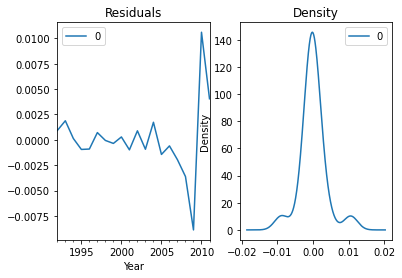

In [295]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [296]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [297]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': 2.851592249865245,
 'me': 0.00010060241173741082,
 'mae': 0.0016084690170897191,
 'mpe': 0.6977928920914469,
 'rmse': 0.0018032027627781087}

## Auto Regressor (AR) model

In [298]:
model_ar = AutoReg(train,lags = 2).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(2)   Log Likelihood                  76.803
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 10 Apr 2022   AIC                           -145.605
Time:                        01:19:12   BIC                           -142.044
Sample:                    01-01-1994   HQIC                          -145.114
                         - 01-01-2011                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.515      0.607      -0.002       0.001
CO2.L1        -0.6159      0.252     -2.446      0.014      -1.109      -0.122
CO2.L2        -0.6954      0.453     -1.534      0.1

In [299]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2012-01-01   -0.009260
2013-01-01    0.006021
2014-01-01    0.002297
2015-01-01   -0.006035
2016-01-01    0.001686
2017-01-01    0.002724
2018-01-01   -0.003284
Freq: AS-JAN, dtype: float64


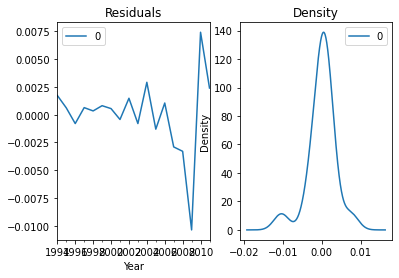

In [300]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [301]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': 66.21910703875352,
 'me': -0.0008544995904721862,
 'mae': 0.004506799524132181,
 'mpe': -12.908929744113681,
 'rmse': 0.005443979416242996}

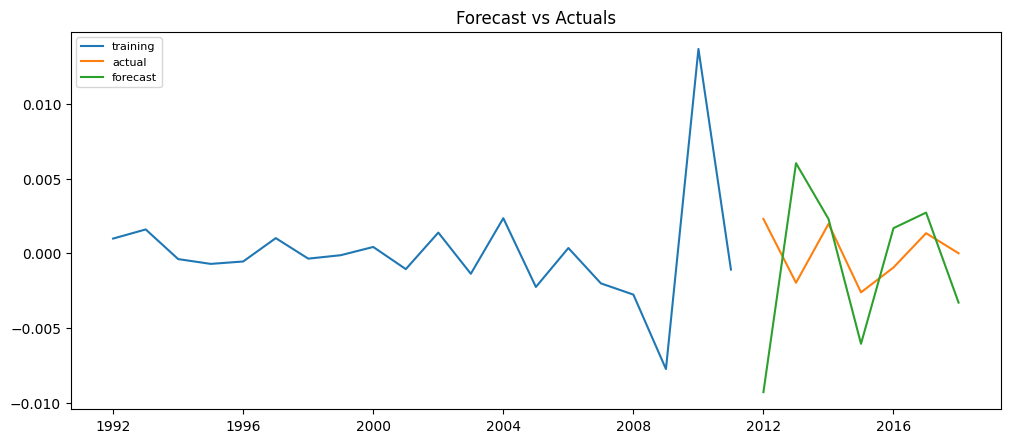

In [302]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [303]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['CO2'],order = (1,0,0))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  84.890
Date:                Sun, 10 Apr 2022   AIC                           -163.779
Time:                        01:19:35   BIC                           -160.792
Sample:                    01-01-1992   HQIC                          -163.196
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.351e-05      0.001      0.109      0.913      -0.001       0.001
ar.L1         -0.3826      0.155     -2.465      0.014      -0.687      -0.078
sigma2      1.192e-05   2.53e-06      4.705      0.000    6.95e-06    1.69e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                12.83
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              34.92   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [304]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

2012-01-01    0.000515
2013-01-01   -0.000095
2014-01-01    0.000138
2015-01-01    0.000049
2016-01-01    0.000083
2017-01-01    0.000070
2018-01-01    0.000075
Freq: AS-JAN, Name: predicted_mean, dtype: float64


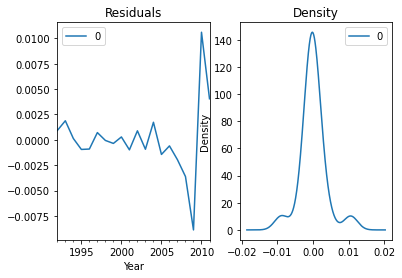

In [305]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [306]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': 2.851592249865245,
 'me': 0.00010060241173741082,
 'mae': 0.0016084690170897191,
 'mpe': 0.6977928920914469,
 'rmse': 0.0018032027627781087}

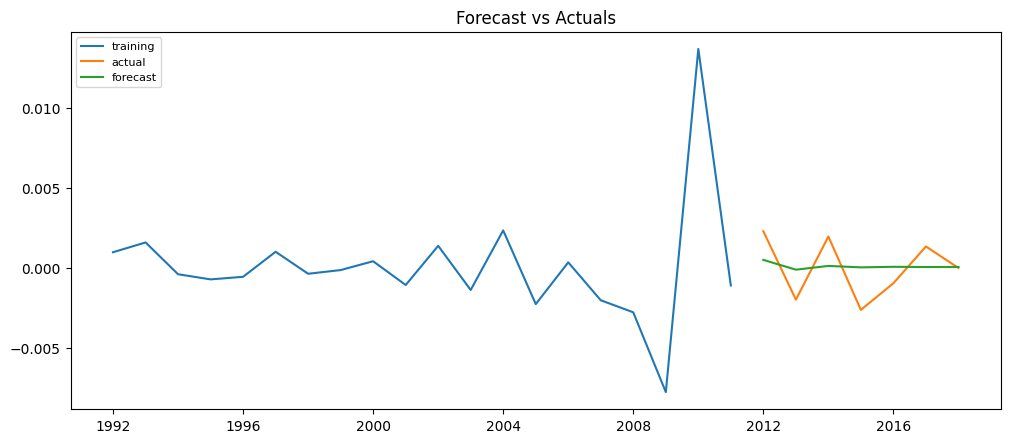

In [307]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [308]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-164.769, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-165.761, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-168.593, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-167.871, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-167.798, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-165.560, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-166.848, Time=0.27 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.879 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  86.297
Date:                Sun, 10 Apr 2022   AIC                           -168.593
Time:                        01:20:02   BIC                           -166.602
Sample:                

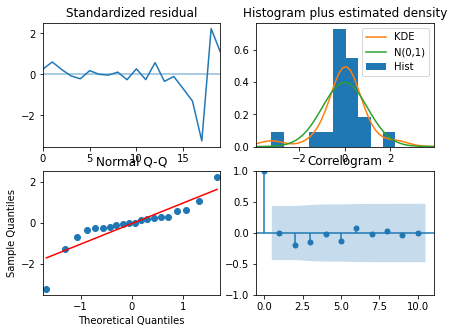

In [309]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [311]:
pred = pd.DataFrame(model.predict(n_periods=7),index=test.index)
pred.columns=['predicted_emission']
print(pred)

            predicted_emission
Year                          
2012-01-01           -0.002159
2013-01-01            0.000000
2014-01-01            0.000000
2015-01-01            0.000000
2016-01-01            0.000000
2017-01-01            0.000000
2018-01-01            0.000000


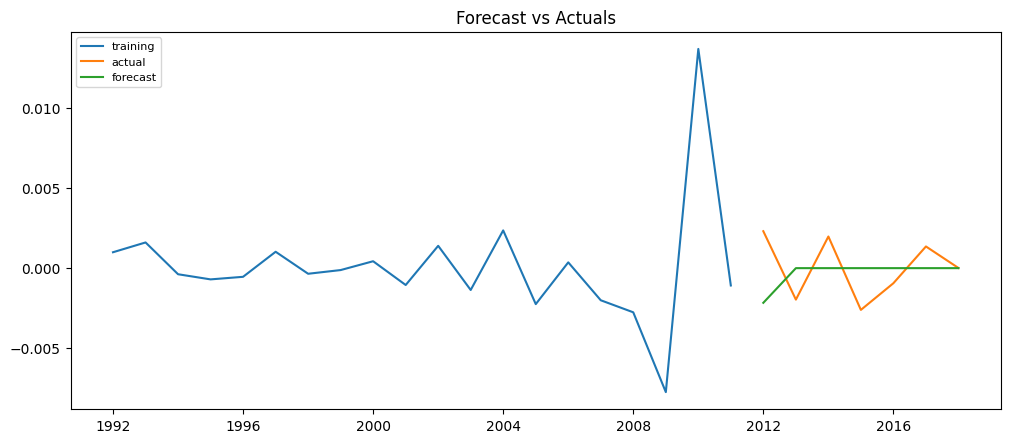

In [312]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [313]:
pred = model.predict(start=start,end=end)
print(pred)

[-0.00215896  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [314]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': 4.115688369685749,
 'me': -0.00023446786821728794,
 'mae': 0.0016613545997470436,
 'mpe': -4.075737424494229,
 'rmse': 0.0019197329486873597}

In [315]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse
#table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
0,ARIMA,0.001803,2.851592,0.000101,0.001608,0.697793
1,Auto Regressor,0.005444,66.219107,-0.000854,0.004507,-12.908930
2,Moving Average,0.001803,2.851592,0.000101,0.001608,0.697793
3,Auto ARIMA,0.001920,4.115688,-0.000234,0.001661,-4.075737


# B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [316]:
df.head()

,CO2
Year,
1990-01-01,0.03348
1991-01-01,0.03274
1992-01-01,0.03299
1993-01-01,0.03484
1994-01-01,0.03631


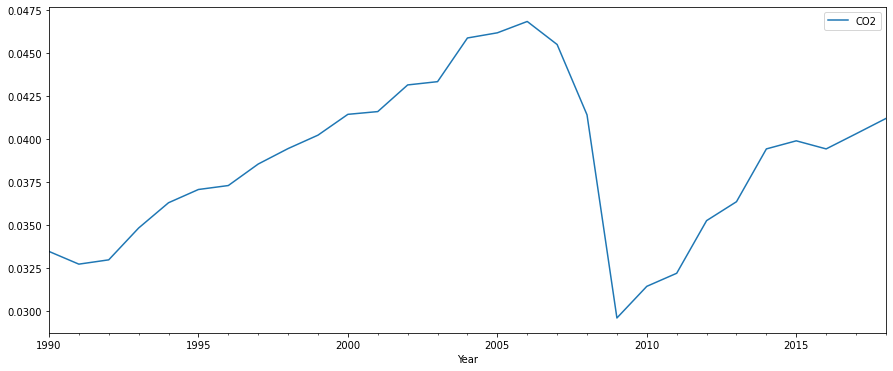

In [317]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [318]:
train = df[:20]
test = df[20:]
print(train.shape,test.shape)

(20, 1) (9, 1)


In [222]:
train.head()

,CO2
Year,
1990-01-01,0.03348
1991-01-01,0.03274
1992-01-01,0.03299
1993-01-01,0.03484
1994-01-01,0.03631


In [223]:
test.head()

,CO2
Year,
2010-01-01,0.03145
2011-01-01,0.03221
2012-01-01,0.03527
2013-01-01,0.03637
2014-01-01,0.03944


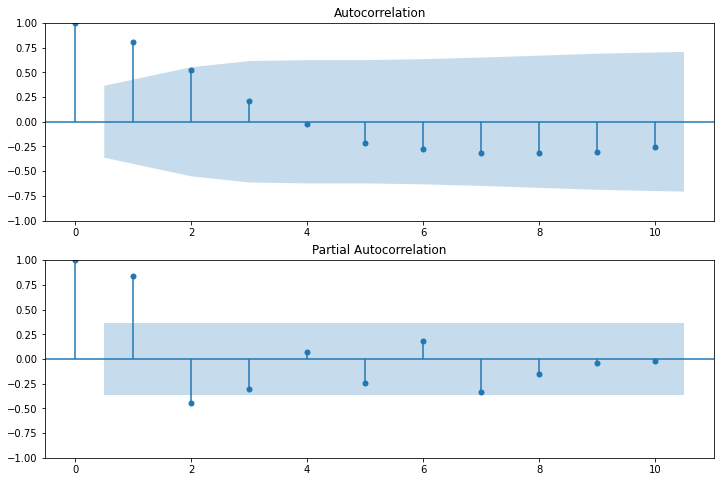

In [319]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=10, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [320]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [321]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [227]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.004
ARIMA(0, 0, 1) RMSE=0.004
ARIMA(0, 0, 2) RMSE=0.004
ARIMA(0, 0, 3) RMSE=0.004
ARIMA(0, 0, 4) RMSE=0.003
ARIMA(0, 1, 0) RMSE=0.002
ARIMA(0, 1, 1) RMSE=0.003
ARIMA(0, 1, 2) RMSE=0.003
ARIMA(0, 1, 3) RMSE=0.004
ARIMA(0, 1, 4) RMSE=0.005
ARIMA(0, 2, 0) RMSE=0.005
ARIMA(0, 2, 1) RMSE=0.005
ARIMA(0, 2, 2) RMSE=0.006
ARIMA(0, 2, 3) RMSE=0.005
ARIMA(0, 2, 4) RMSE=0.005
ARIMA(0, 3, 0) RMSE=0.009
ARIMA(0, 3, 1) RMSE=0.008
ARIMA(0, 3, 2) RMSE=0.009
ARIMA(0, 3, 3) RMSE=0.008
ARIMA(0, 3, 4) RMSE=0.059
ARIMA(0, 4, 0) RMSE=0.017
ARIMA(0, 4, 1) RMSE=0.016
ARIMA(0, 4, 2) RMSE=0.015
ARIMA(0, 4, 3) RMSE=0.016
ARIMA(1, 0, 0) RMSE=0.001
ARIMA(1, 0, 1) RMSE=0.002
ARIMA(1, 0, 2) RMSE=0.004
ARIMA(1, 0, 3) RMSE=0.004
ARIMA(1, 0, 4) RMSE=0.005
ARIMA(1, 1, 0) RMSE=0.004
ARIMA(1, 1, 1) RMSE=0.004
ARIMA(1, 1, 2) RMSE=0.005
ARIMA(1, 1, 3) RMSE=0.005
ARIMA(1, 1, 4) RMSE=0.005
ARIMA(1, 2, 0) RMSE=0.007
ARIMA(1, 2, 1) RMSE=0.006
ARIMA(1, 2, 2) RMSE=0.005
ARIMA(1, 2, 3) RMSE=0.006
ARIMA(1, 2, 

## ARIMA

In [322]:
model_arima = ARIMA(train['CO2'],order = (1,0,0))
model_arima = model_arima.fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   20
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  87.515
Date:                Sun, 10 Apr 2022   AIC                           -169.031
Time:                        01:21:43   BIC                           -166.043
Sample:                    01-01-1990   HQIC                          -168.447
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.011      3.256      0.001       0.015       0.059
ar.L1          0.8472      0.309      2.744      0.006       0.242       1.452
sigma2      8.667e-06   2.03e-06      4.274      0.000    4.69e-06    1.26e-05
===================================================================================
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):                78.38
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):              18.77   Skew:                            -2.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [323]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2010-01-01    0.030677
2011-01-01    0.031581
2012-01-01    0.032347
2013-01-01    0.032996
2014-01-01    0.033546
2015-01-01    0.034012
2016-01-01    0.034407
2017-01-01    0.034741
2018-01-01    0.035024
Freq: AS-JAN, Name: predicted_mean, dtype: float64


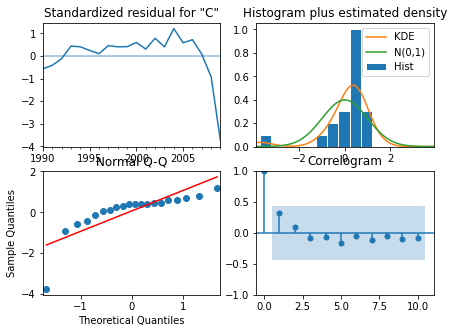

In [324]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

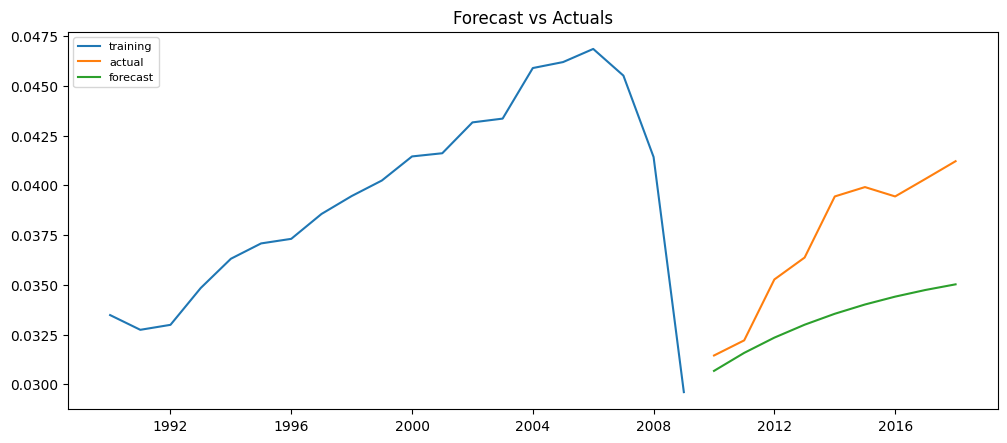

In [325]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [326]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mape': 0.10367006942129169,
 'me': -0.0040319806392635545,
 'mae': 0.0040319806392635545,
 'mpe': -0.10367006942129169,
 'rmse': 0.004535815419481601}

## Auto ARIMA

In [327]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-165.501, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-164.146, Time=0.22 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-163.515, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-166.126, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-162.622, Time=0.31 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.971 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  84.063
Date:                Sun, 10 Apr 2022   AIC                           -166.126
Time:                        01:22:15   BIC                           -165.236
Sample:                             0   HQIC                          -166.003
                                 - 20                                       

In [328]:
pred_auto_arima = pd.DataFrame(model_auto.predict(n_periods=9),index=test.index)
pred_auto_arima.columns=['predicted_emission']
print(pred_auto_arima)

            predicted_emission
Year                          
2010-01-01            0.017800
2011-01-01            0.005990
2012-01-01           -0.005821
2013-01-01           -0.017631
2014-01-01           -0.029441
2015-01-01           -0.041251
2016-01-01           -0.053061
2017-01-01           -0.064871
2018-01-01           -0.076682


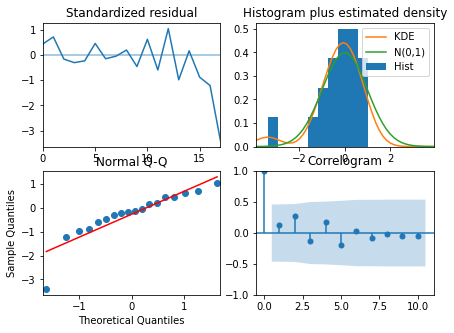

In [329]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

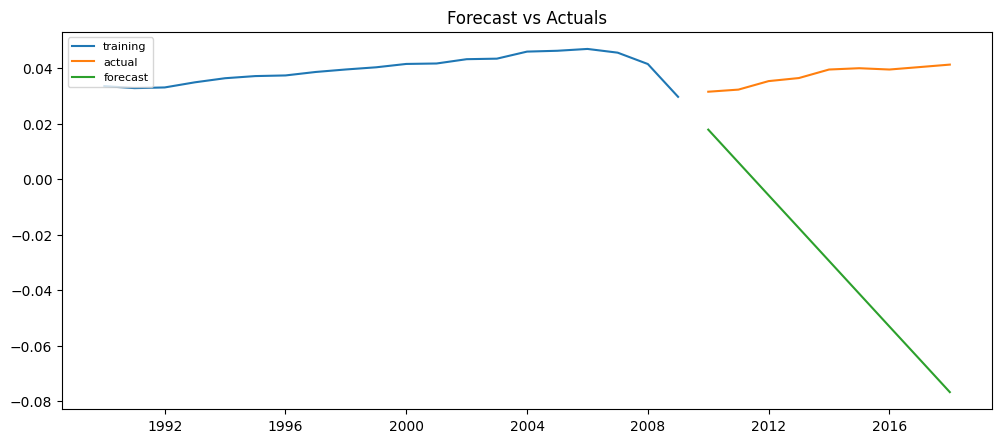

In [330]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor 

In [352]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(1)   Log Likelihood                  83.502
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 10 Apr 2022   AIC                           -161.004
Time:                        01:25:43   BIC                           -158.171
Sample:                    01-01-1991   HQIC                          -160.525
                         - 01-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.006      0.938      0.348      -0.006       0.018
CO2.L1         0.8504      0.153      5.558      0.000       0.551       1.150
                                    Roots           

In [353]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2010-01-01    0.030948
2011-01-01    0.032086
2012-01-01    0.033053
2013-01-01    0.033876
2014-01-01    0.034576
2015-01-01    0.035171
2016-01-01    0.035677
2017-01-01    0.036108
2018-01-01    0.036474
Freq: AS-JAN, dtype: float64


In [354]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': 0.11076234309126448,
 'me': -0.0030722057447410056,
 'mae': 0.004243623877798169,
 'mpe': -0.07409529441630794,
 'rmse': 0.0049327041921915634}

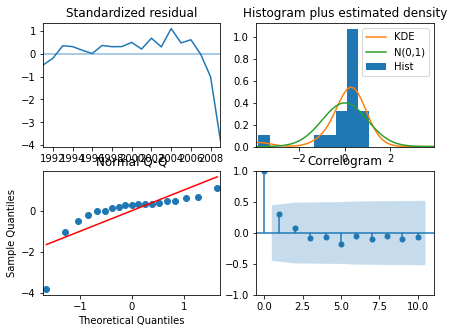

In [355]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

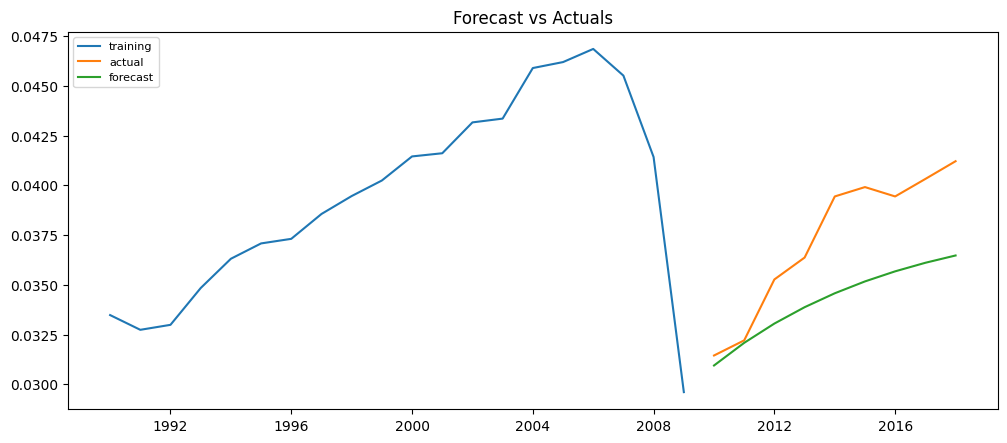

In [356]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Single Exponential Smoothing

In [357]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

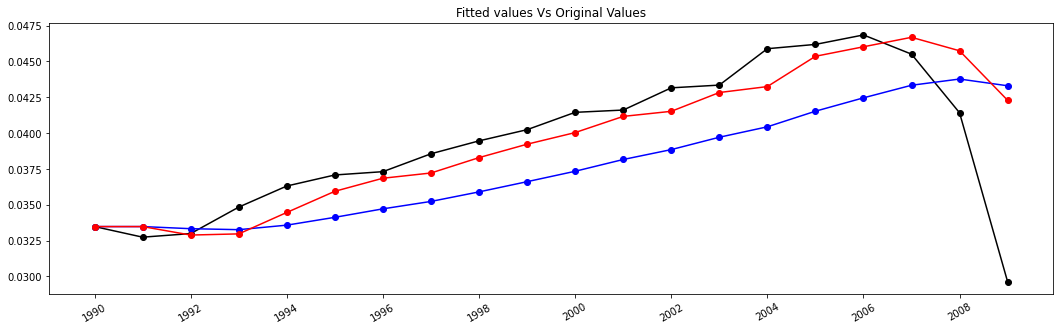

In [358]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [359]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [360]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mape': 0.101081059841033,
 'me': 0.003273142632765551,
 'mae': 0.0034166418007929586,
 'mpe': 0.09759891550646839,
 'rmse': 0.004736579322895556}

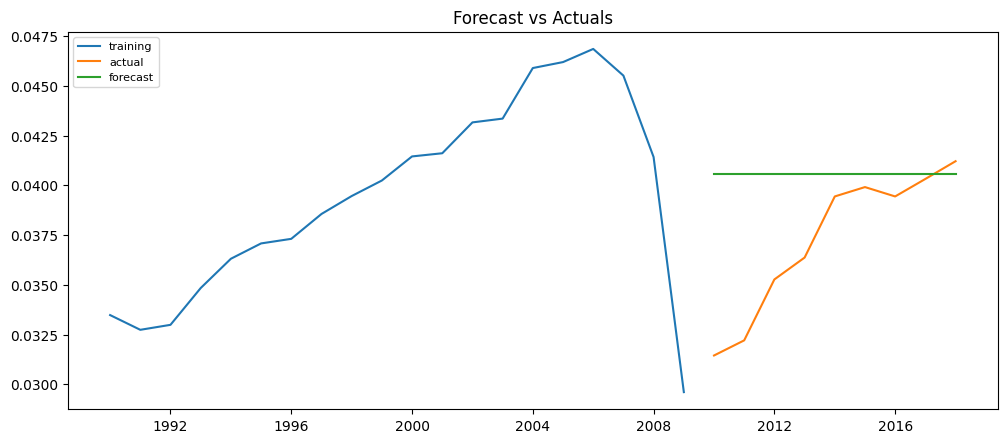

In [361]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [362]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

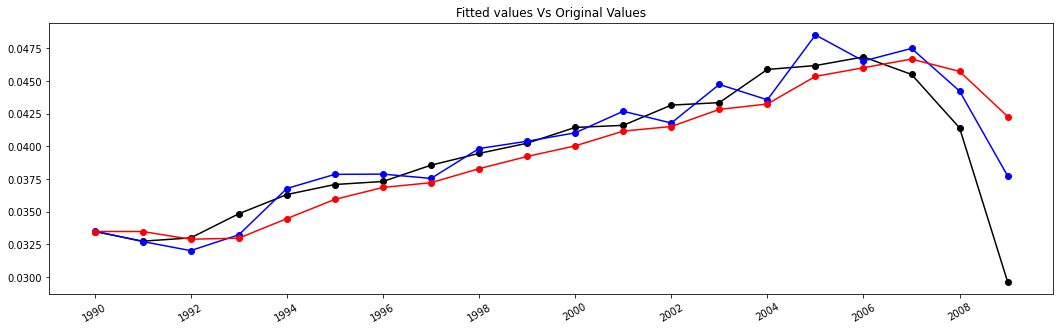

In [363]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [364]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [365]:
ns_des_acc = forecast_accuracy(pred_holt,test.CO2)
ns_des_acc

{'mape': 0.7694342218402953,
 'me': -0.029376432810334592,
 'mae': 0.029376432810334592,
 'mpe': -0.7694342218402953,
 'rmse': 0.030937204773720958}

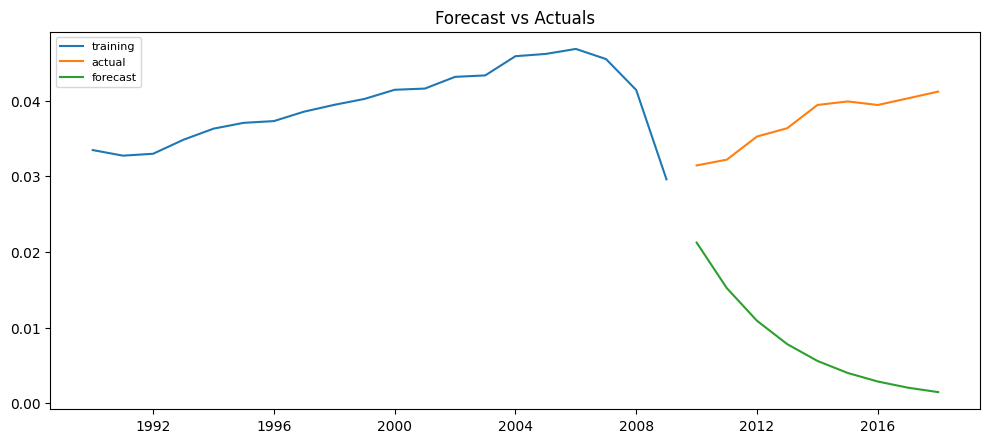

In [366]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Triple Exponential Smoothing or Holt - Winter's Method

**seasonality = additive** , **Trend = additive**

In [367]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [368]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.CO2)
ns_tes_add_add_acc

{'mape': 1.552919723633846,
 'me': -0.06017991924735,
 'mae': 0.06017991924735,
 'mpe': -1.552919723633846,
 'rmse': 0.06729098273928132}

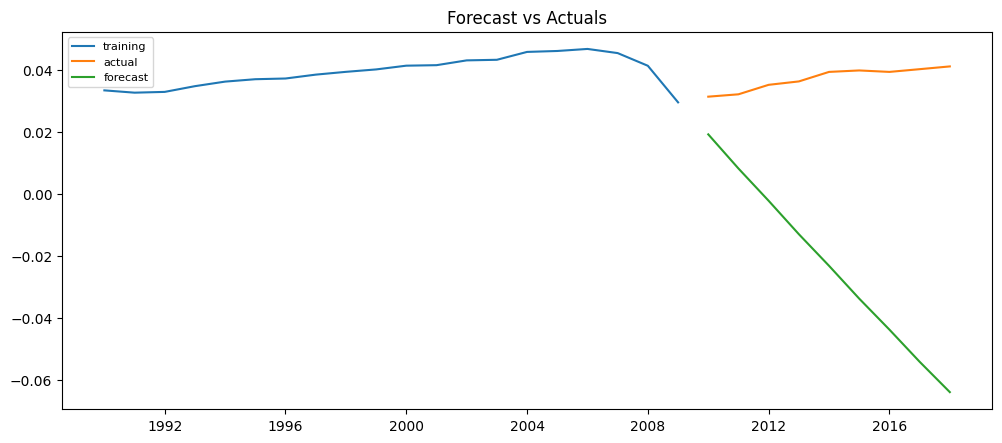

In [369]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative** , **Trend = additive**

In [370]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [371]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.CO2)
ns_tes_mul_add_acc

{'mape': 1.617169523350437,
 'me': -0.06270746302982837,
 'mae': 0.06270746302982837,
 'mpe': -1.617169523350437,
 'rmse': 0.07034525833504846}

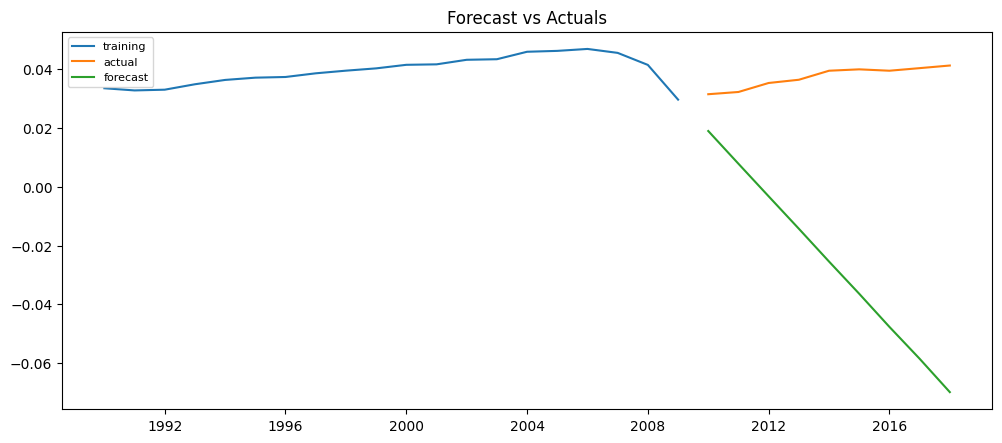

In [372]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative , Trend = multiplicative**

In [373]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [374]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.CO2)
ns_tes_mul_mul_acc

{'mape': 1.617169523350437,
 'me': -0.06270746302982837,
 'mae': 0.06270746302982837,
 'mpe': -1.617169523350437,
 'rmse': 0.07034525833504846}

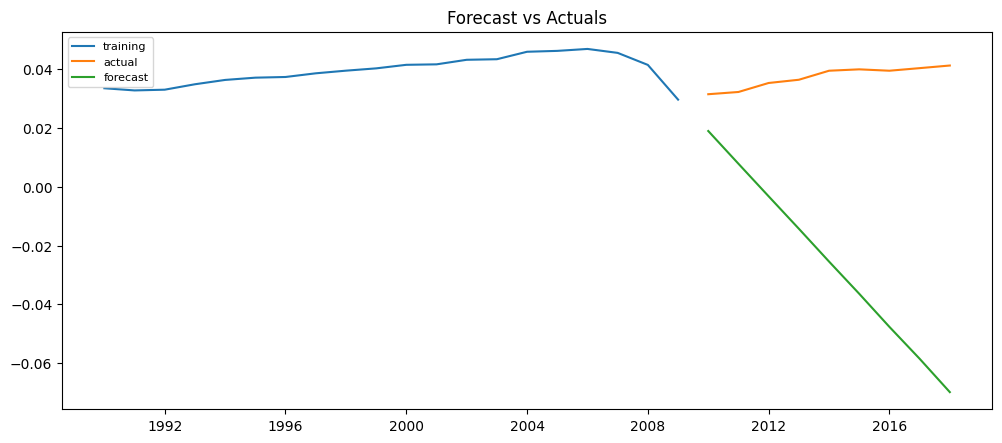

In [375]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [376]:
scaler = MinMaxScaler()

In [377]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [378]:
scaled_train[:10]

array([[0.22447796],
       [0.18155452],
       [0.19605568],
       [0.30336427],
       [0.38863109],
       [0.43329466],
       [0.44663573],
       [0.51914153],
       [0.57134571],
       [0.61658933]])

In [379]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [380]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.22447796 0.18155452 0.19605568 0.30336427 0.38863109]
predict this y: 
 [[0.43329466]]


In [381]:
X.shape

(1, 5, 1)

In [382]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [383]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 60)             14880     
                                                                 
 dropout (Dropout)           (None, 5, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_1 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_2 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [384]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
15/15 [==============================] - 10s 21ms/step - loss: 0.4671
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 0.3017
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1401
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.0943
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0533
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 0.0862
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0919
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0612
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0977
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0788
Epoch 11/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0563
Epoch 12/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0755
Epoch 13/50
15/15 [=================

Text(0.5, 1.0, 'Loss per Epochs')

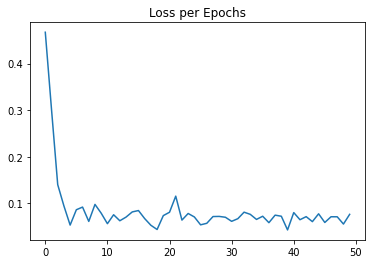

In [385]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [386]:
last_train_batch = scaled_train[-5:]

In [387]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [388]:
model.predict(last_train_batch)

array([[0.7155081]], dtype=float32)

In [389]:
scaled_test[0]

array([0.10672854])

In [390]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [391]:
test_predictions

[array([0.7155081], dtype=float32),
 array([0.699325], dtype=float32),
 array([0.67364985], dtype=float32),
 array([0.6451038], dtype=float32),
 array([0.6230857], dtype=float32),
 array([0.68649536], dtype=float32),
 array([0.6837016], dtype=float32),
 array([0.68171024], dtype=float32),
 array([0.68055886], dtype=float32)]

In [392]:
test.head()

,CO2
Year,
2010-01-01,0.03145
2011-01-01,0.03221
2012-01-01,0.03527
2013-01-01,0.03637
2014-01-01,0.03944


In [393]:
true_predictions = scaler.inverse_transform(test_predictions)

In [394]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Year'>

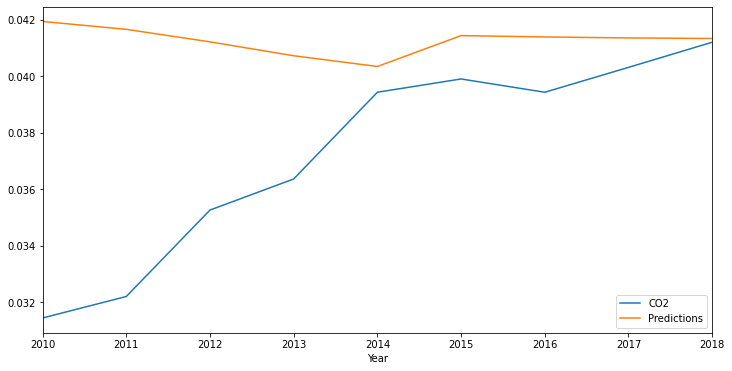

In [395]:
test.plot(figsize=(12,6))

In [396]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mape': 0.11736896777224258,
 'me': 0.003982971986134853,
 'mae': 0.003982971986134853,
 'mpe': 0.11736896777224258,
 'rmse': 0.005397210520096837}

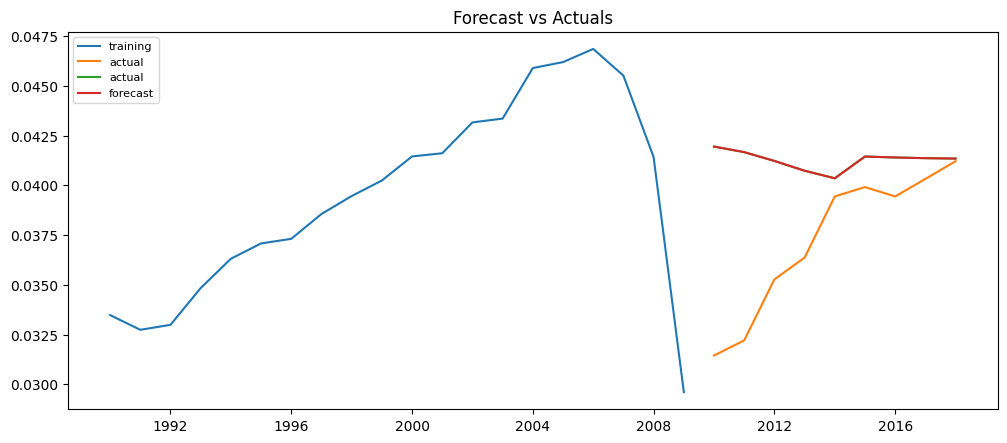

In [397]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [398]:
data = {"MODEL":pd.Series(["ARIMA(1,0,0)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
2,single exponential smoothing,0.004737,0.101081,0.003273,0.003417,0.097599
0,"ARIMA(1,0,0)",0.004536,0.103670,-0.004032,0.004032,-0.103670
1,Auto Regressor,0.004933,0.110762,-0.003072,0.004244,-0.074095
7,LSTM(RNN),0.005397,0.117369,0.003983,0.003983,0.117369
3,Double exponential smoothing,0.030937,0.769434,-0.029376,0.029376,-0.769434
4,Triple exponential smoothing(additive seasonal...,0.067291,1.552920,-0.060180,0.060180,-1.552920
5,Triple exponential smoothing(multiplicative se...,0.070345,1.617170,-0.062707,0.062707,-1.617170
6,Triple exponential smoothing(multiplicative se...,0.070345,1.617170,-0.062707,0.062707,-1.617170


# Final Model

We have selected **ARIMA** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [507]:
""" final_model_ar = AutoReg(df['CO2'],lags=6).fit()
print(final_model_ar.summary()) """

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   29
Model:                     AutoReg(6)   Log Likelihood                  51.246
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Sat, 09 Apr 2022   AIC                            -86.492
Time:                        23:06:07   BIC                            -77.408
Sample:                    01-01-1996   HQIC                           -84.207
                         - 01-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0710      0.116      0.610      0.542      -0.157       0.299
CO2.L1         0.6256      0.215      2.910      0.004       0.204       1.047
CO2.L2        -0.3512      0.260     -1.351      0.1

In [500]:
""" final_model_ar = AutoReg(train,lags = 6).fit()
print(final_model_ar.summary())
final_arima = ARIMA(df['CO2'],order = (2,1,2))
final_arima = final_arima.fit()
final_arima.summary() """

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                   20
Model:                     AutoReg(6)   Log Likelihood                  35.474
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Sat, 09 Apr 2022   AIC                            -54.948
Time:                        22:58:16   BIC                            -49.835
Sample:                    01-01-1996   HQIC                           -55.421
                         - 01-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1376      0.485      2.347      0.019       0.187       2.088
CO2.L1         0.4546      0.267      1.701      0.089      -0.069       0.978
CO2.L2        -0.4555      0.292     -1.557      0.1

In [399]:

final_arima = ARIMA(df['CO2'],order = (1,0,0))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   29
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 131.163
Date:                Sun, 10 Apr 2022   AIC                           -256.326
Time:                        01:56:13   BIC                           -252.224
Sample:                    01-01-1990   HQIC                          -255.042
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0384      0.003     11.455      0.000       0.032       0.045
ar.L1          0.8239      0.174      4.731      0.000       0.483       1.165
sigma2      6.612e-06   1.11e-06      5.954      0.000    4.44e-06    8.79e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.92   Jarque-Bera (JB):               195.36
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               9.17   Skew:                            -3.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [400]:
final_arima.fittedvalues.tail()

Year
2014-01-01    0.036727
2015-01-01    0.039257
2016-01-01    0.039644
2017-01-01    0.039257
2018-01-01    0.039982
dtype: float64

In [508]:
""" final_model_ar.fittedvalues.tail() """

Year
2014-01-01    0.552585
2015-01-01    0.513923
2016-01-01    0.501401
2017-01-01    0.508658
2018-01-01    0.517853
dtype: float64

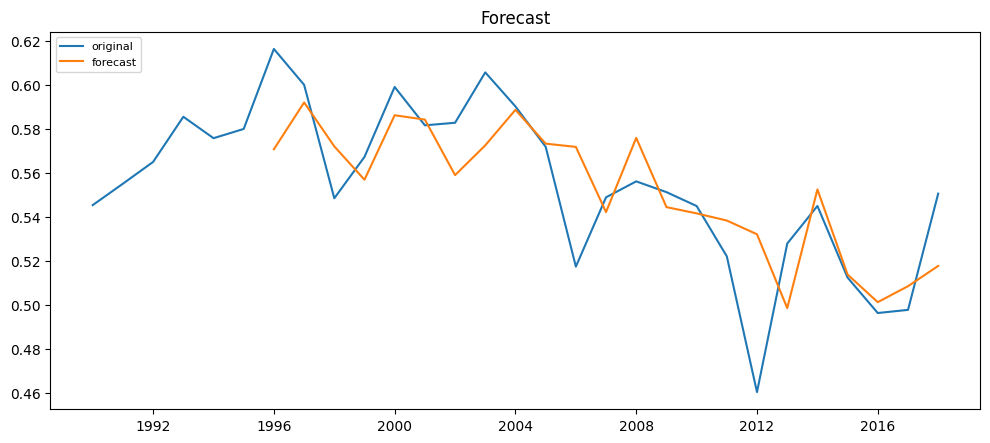

In [509]:
""" plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_model_ar.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show() """

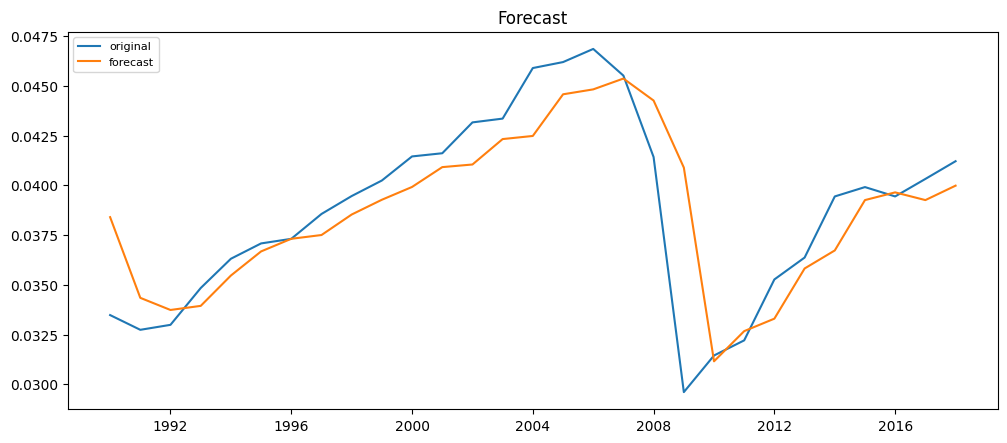

In [401]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show() 

### creating dataframe for future forecasting

In [402]:
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [403]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [404]:
future_df.tail()

,CO2
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN


In [405]:
len(future_df)

5

### Forecasting for  next 5 years using Final AR model

In [406]:
future_df['CO2'] = final_arima.predict(start = 29, end = 34, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')

In [515]:
""" future_df['CO2'] =final_model_ar.predict(start = 29, end = 34, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years') """


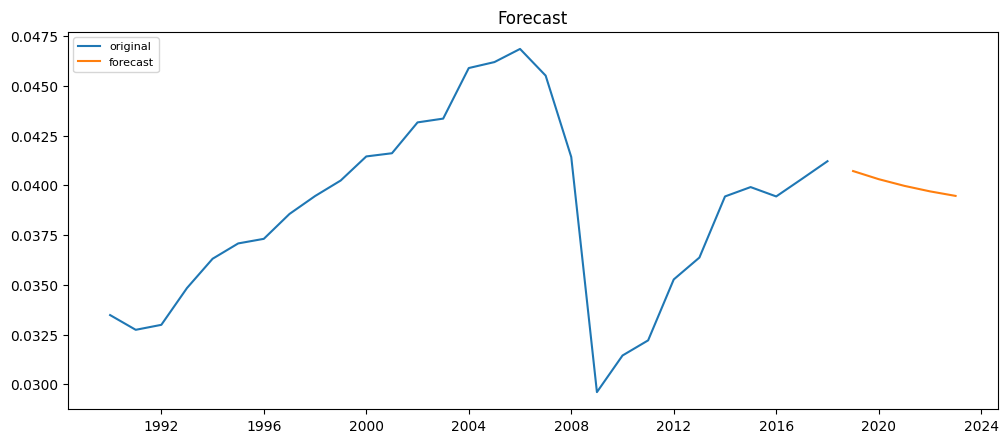

In [407]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [408]:
df.tail()

,CO2
Year,
2014-01-01,0.03944
2015-01-01,0.03991
2016-01-01,0.03944
2017-01-01,0.04032
2018-01-01,0.04121


In [409]:
future_df.tail()

,CO2
2019-01-01,0.040715
2020-01-01,0.040308
2021-01-01,0.039972
2022-01-01,0.039695
2023-01-01,0.039467


In [410]:
# Exporting to csv file
future_df.to_csv(r'forecast_industries_data_5years.csv',index=True)

## Forecast for 10 years

In [411]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [412]:
future_df_10['CO2'] = final_arima.predict(start = 29, end = 39, dynamic= True) 

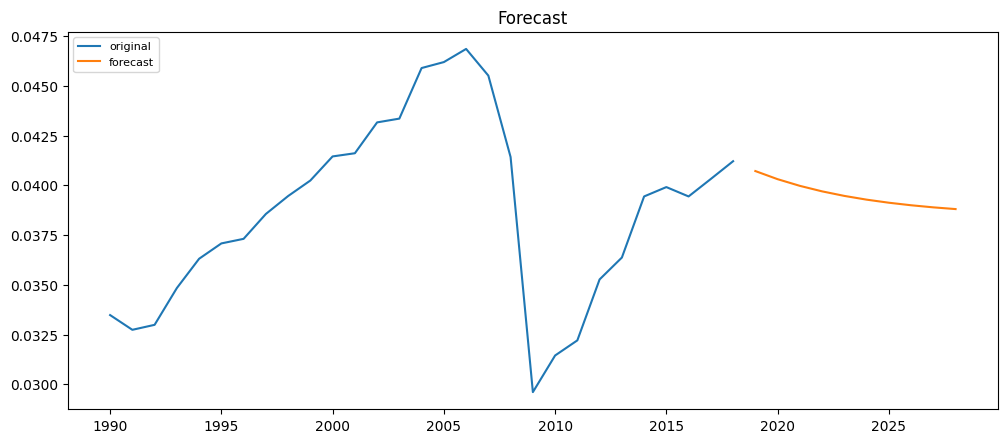

In [413]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [414]:
future_df_10

,CO2
2019-01-01,0.040715
2020-01-01,0.040308
2021-01-01,0.039972
2022-01-01,0.039695
2023-01-01,0.039467
2024-01-01,0.039279
2025-01-01,0.039124
2026-01-01,0.038997
2027-01-01,0.038892
2028-01-01,0.038805


In [415]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_industry_10years.csv',index=True)

In [416]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_ARIMA_industry.pkl','wb'))